In [9]:
# =====================================
# 1. Import
# =====================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# =====================================
# 2. Load data
# =====================================
df = pd.read_csv("hotel_booking.csv")

X = df.drop('is_canceled', axis=1)
y = df['is_canceled']
print("Shape ban đầu:", df.shape)


# =====================================
# 3. Drop useless / ID columns
# =====================================
cols_to_drop = [
    'phone-number',
    'email',
    'name',
    'reservation_id',
    'reservation_status',
    'reservation_status_date',
    'agent',
    'company'
]
X = X.drop(columns=[c for c in cols_to_drop if c in X.columns])


# =====================================
# 4. Train / Test split (RẤT QUAN TRỌNG)
# =====================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

# =====================================
# 5. Handle missing values (fit on train)
# =====================================
num_cols = X_train.select_dtypes(include='number').columns
cat_cols = X_train.select_dtypes(include='object').columns

# Numeric
X_train[num_cols] = X_train[num_cols].fillna(X_train[num_cols].mean())
X_test[num_cols]  = X_test[num_cols].fillna(X_train[num_cols].mean())

# Categorical
for col in cat_cols:
    mode_val = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(mode_val)
    X_test[col]  = X_test[col].fillna(mode_val)


# =====================================
# 6. Handle RARE categories (QUAN TRỌNG)
# =====================================
def handle_rare_categories(train_col, test_col, min_freq=10):
    valid = train_col.value_counts()
    valid = valid[valid >= min_freq].index
    train_col = train_col.where(train_col.isin(valid), 'OTHER')
    test_col  = test_col.where(test_col.isin(valid), 'OTHER')
    return train_col, test_col

for col in cat_cols:
    X_train[col], X_test[col] = handle_rare_categories(
        X_train[col], X_test[col], min_freq=10
    )


# =====================================
# 7. Encoding (LabelEncoder – SAFE)
# =====================================
for col in cat_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col]  = le.transform(X_test[col])


# =====================================
# 8. Scaling (ONLY numeric columns)
# =====================================
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test[num_cols])


# =====================================
# 9. SMOTE (ONLY on TRAIN)
# =====================================
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(
    X_train_scaled, y_train
)
print("Train sau SMOTE:", X_train_smote.shape)
print("\nMissing values sau tiền xử lý (TRAIN):")
print(X_train.isnull().sum().sum())
print("Missing values sau tiền xử lý (TEST):")
print(X_test.isnull().sum().sum())
print("\nPhân bố lớp TRƯỚC SMOTE:")
print(y_train.value_counts(normalize=True))

print("\nPhân bố lớp SAU SMOTE:")
print(pd.Series(y_train_smote).value_counts(normalize=True))
print("\nSố category ban đầu (TRAIN):")
for col in cat_cols:
    print(col, X_train[col].nunique())
print("\nSố lượng giá trị 'OTHER' sau gộp:")
for col in cat_cols:
    if 'OTHER' in X_train[col].values:
        print(col, (X_train[col] == 'OTHER').sum())
print("\nThống kê biến số SAU CHUẨN HÓA (TRAIN):")
print(X_train_scaled[num_cols].describe().loc[['mean', 'std']])
print("\nSố cột TRAIN:", X_train_scaled.shape[1])
print("Số cột TEST :", X_test_scaled.shape[1])




Shape ban đầu: (119390, 36)
Train shape: (95512, 28)
Test shape : (23878, 28)
Train sau SMOTE: (120266, 28)

Missing values sau tiền xử lý (TRAIN):
0
Missing values sau tiền xử lý (TEST):
0

Phân bố lớp TRƯỚC SMOTE:
is_canceled
0    0.629586
1    0.370414
Name: proportion, dtype: float64

Phân bố lớp SAU SMOTE:
is_canceled
0    0.5
1    0.5
Name: proportion, dtype: float64

Số category ban đầu (TRAIN):
hotel 2
arrival_date_month 12
meal 5
country 91
market_segment 8
distribution_channel 5
reserved_room_type 10
assigned_room_type 12
deposit_type 3
customer_type 4
credit_card 5492

Số lượng giá trị 'OTHER' sau gộp:

Thống kê biến số SAU CHUẨN HÓA (TRAIN):
         lead_time  arrival_date_year  arrival_date_week_number  \
mean  4.017224e-17      -2.244549e-14             -1.100273e-16   
std   1.000005e+00       1.000005e+00              1.000005e+00   

      arrival_date_day_of_month  stays_in_weekend_nights  \
mean               2.231791e-17            -2.343381e-17   
std             

Logistic Regression

In [10]:
# =====================================
# 10. Logistic Regression (BASELINE)
# =====================================
log_model = LogisticRegression(
    max_iter=1000,
    random_state=42
)

log_model.fit(X_train_smote, y_train_smote)

y_pred = log_model.predict(X_test_scaled)

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

=== Logistic Regression ===
Accuracy: 0.7562191138286288
[[11647  3386]
 [ 2435  6410]]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80     15033
           1       0.65      0.72      0.69      8845

    accuracy                           0.76     23878
   macro avg       0.74      0.75      0.74     23878
weighted avg       0.76      0.76      0.76     23878

=== Logistic Regression ===
Accuracy: 0.7562191138286288
              precision    recall  f1-score   support

           0       0.83      0.77      0.80     15033
           1       0.65      0.72      0.69      8845

    accuracy                           0.76     23878
   macro avg       0.74      0.75      0.74     23878
weighted avg       0.76      0.76      0.76     23878



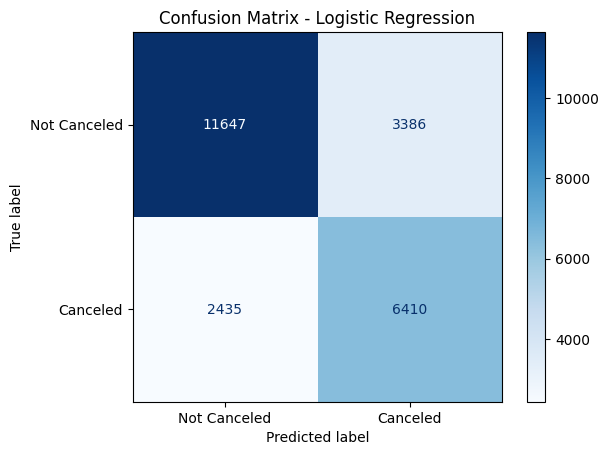

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Canceled', 'Canceled'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

Decision Tree


In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

print("=== Decision Tree (NO SMOTE) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


=== Decision Tree (NO SMOTE) ===
Accuracy: 0.8272049585392411
              precision    recall  f1-score   support

           0       0.88      0.85      0.86     15033
           1       0.75      0.80      0.77      8845

    accuracy                           0.83     23878
   macro avg       0.81      0.82      0.82     23878
weighted avg       0.83      0.83      0.83     23878



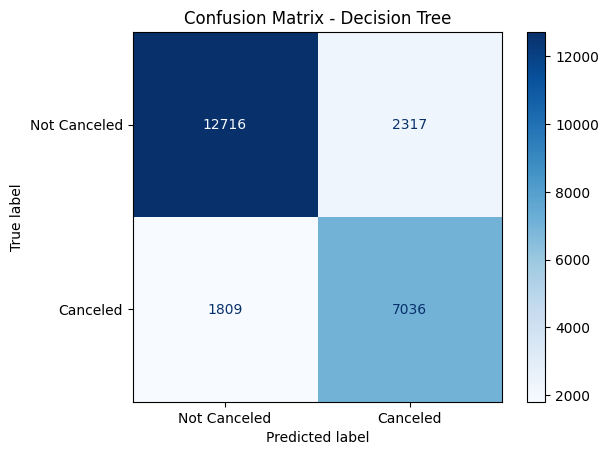

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Canceled', 'Canceled'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Decision Tree')
plt.show()

Random Forest


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

=== Random Forest ===
Accuracy: 0.8844543094061479
[[13883  1150]
 [ 1609  7236]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     15033
           1       0.86      0.82      0.84      8845

    accuracy                           0.88     23878
   macro avg       0.88      0.87      0.87     23878
weighted avg       0.88      0.88      0.88     23878



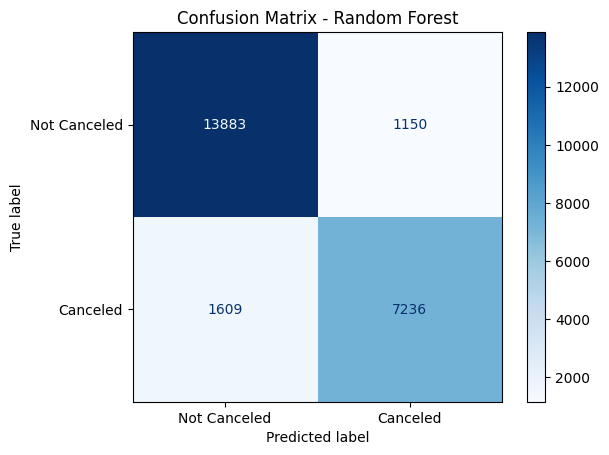

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Canceled', 'Canceled'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest')
plt.show()

XG Boost


In [32]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("=== XGBoost ===")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


=== XGBoost ===
Accuracy: 0.8741100594689672
[[13859  1174]
 [ 1832  7013]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     15033
           1       0.86      0.79      0.82      8845

    accuracy                           0.87     23878
   macro avg       0.87      0.86      0.86     23878
weighted avg       0.87      0.87      0.87     23878



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Canceled', 'Canceled'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - XGBoost')
plt.show()

So sánh các mô hình